In [9]:
%cd ~/code/projects/nn-play/

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
import os
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
%matplotlib inline

from structured_container import DataContainer
from torch_nets import *
import my_utils

/home/ira/code/projects/nn-play


In [10]:
BATCH_SIZE = 4
EP_LEN = 120
V_SIZE = 256
GUARANTEED_PERCEPTS = 6
UNCERTAIN_PERCEPTS = 4
EPOCHS = 225
UPDATES_PER_EPOCH = 1000
OUTPUT_FOLDER = "/home/ira/code/projects/nn-play/experiments/1b_pass_det/"

In [11]:
data_test = DataContainer('/home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/test.pt', batch_size=BATCH_SIZE, ep_len_read=EP_LEN)
data_test.populate_images()

Loading /home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/test.pt


In [12]:
def mask_percepts(images, p, return_indices=False):
    images_masked = np.copy(images)
    if p < 1.0:
        for_removal = np.random.random(EP_LEN) < p
    else:
        for_removal = np.ones(EP_LEN) > 0

    if UNCERTAIN_PERCEPTS > 0:
        clear_percepts = GUARANTEED_PERCEPTS + np.random.randint(0, UNCERTAIN_PERCEPTS)
    else:
        clear_percepts = GUARANTEED_PERCEPTS
    for_removal[0:clear_percepts] = False
    images_masked[:, for_removal, ...] = 0

    if return_indices:
        return images_masked, for_removal
    else:
        return images_masked

In [13]:
net = PredictiveAutoencoder(v_size=V_SIZE)
net.load_state_dict(torch.load("%s/autencoder_epoch_4.pth" % OUTPUT_FOLDER))

In [14]:
criterion = nn.MSELoss()
x = torch.FloatTensor(EP_LEN, BATCH_SIZE, IM_CHANNELS, IM_WIDTH, IM_WIDTH)
y = torch.FloatTensor(EP_LEN, BATCH_SIZE, IM_CHANNELS, IM_WIDTH, IM_WIDTH)

net = net.cuda()
criterion = criterion.cuda()

In [15]:
x = data_test.images
# x = mask_percepts(x, p=10.99)
x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
x = x.cuda()
x = Variable(x)

In [16]:
# recon_ims = recon.data.cpu().numpy()
# target_ims = x.data.cpu().numpy()
# joint = np.concatenate((target_ims, recon_ims), axis=-2)
# my_utils.batch_to_sequence(joint, fpath='%s/massive.gif' % (OUTPUT_FOLDER))

In [17]:
x = data_test.images[:100, ...]
# x = mask_percepts(x, p=0.99)
x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
x = x.cuda()
x = Variable(x)
crisp_states = net.bs_prop(x).data.cpu().numpy()

In [18]:
x = data_test.images
x = mask_percepts(x, p=0.99)
x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
x = x.cuda()
x = Variable(x)
belief_states = net.bs_prop(x).data.cpu().numpy()

In [19]:
x.size()

torch.Size([120, 200, 1, 28, 28])

(array([ 780153.,  275019.,  206805.,  186477.,  189396.,  182173.,
         184536.,  198584.,  247138.,  621719.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

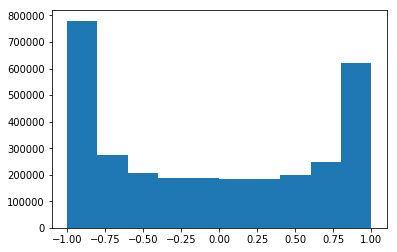

In [20]:
plt.hist(crisp_states[:,:,:].flatten())

(array([  122.,   168.,   565.,  1132.,  1670.,  1223.,  1394.,  1726.,
         2018.,  1982.]),
 array([-0.84040809, -0.65727358, -0.47413908, -0.29100458, -0.10787008,
         0.07526442,  0.25839893,  0.44153343,  0.62466793,  0.80780243,
         0.99093693]),
 <a list of 10 Patch objects>)

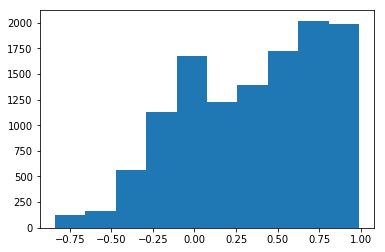

In [27]:
plt.hist(crisp_states[:,:,15].flatten())

(array([ 1324.,  1815.,  2583.,  2386.,  3271.,  3629.,  3349.,  2538.,
         2029.,  1076.]),
 array([-0.94122034, -0.75554274, -0.56986513, -0.38418753, -0.19850992,
        -0.01283231,  0.17284529,  0.3585229 ,  0.5442005 ,  0.72987811,
         0.91555572]),
 <a list of 10 Patch objects>)

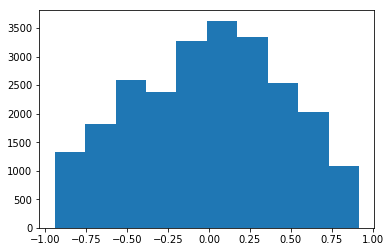

In [28]:
plt.hist(belief_states[:,:,15].flatten())

(array([ 578645.,  439509.,  515248.,  638343.,  876877.,  865235.,
         649697.,  526965.,  477301.,  576180.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

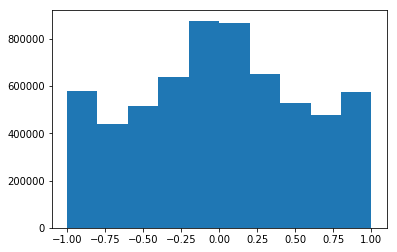

In [29]:
plt.hist(belief_states[:,:,:].flatten())